In [1]:
!pip install tensorflow

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
import os
import time
import pickle

In [67]:
class Pipeline:
    
    def __init__(self, batch_size = 100, epochs = 1, optimizer_lr = 0.0007):
        
        #dataset directory
        self.ROOT = pathlib.Path.cwd()/'PACKAGE'
        self.DATASET_DIR = self.ROOT/'DATASET'
        self.MODEL_DIR = self.ROOT/'MODEL'
        
        #data
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        
        self.train_dataset = None
        self.test_dataset = None
        
        #parameters
        self.class_mapper = class_mapper = {0:'T-shirt', 1:'Trouser', 2:'Pullover', 3:'Dress', 4:'Coat', 5:'Sandal', 6:'Shirt',
               7:'Sneaker', 8:'Bag', 9:'Ankle boot'}
        
        self.input_shape = None
        
        #model
        self.model = None
        self.batch_size = batch_size 
        self.epochs = epochs 
        self.optimizer_lr = optimizer_lr
        
    def create_directory(self):
        start = time.time()
        template = [self.ROOT, self.DATASET_DIR]
        for directory in template:
            if directory.exists() == True:
                continue
            else:
                os.mkdir(directory)
        stop = time.time()
        total_time = stop - start
        print('Directory created, it took {0} s'.format(round(total_time, ndigits = 2)))
        del template
        
        

    def data_load_and_save(self):

        start = time.time()
        (self.X_train, self.y_train),(self.X_test, self.y_test) = tf.keras.datasets.fashion_mnist.load_data()
        stop = time.time()
        
        self.input_shape = tf.expand_dims(self.X_train[0], axis = 2).shape
        total_time = stop - start
        
        with open(self.DATASET_DIR/'X_train.pkl', 'wb') as file:
            pickle.dump(self.X_train, file)
        with open(self.DATASET_DIR/'X_test.pkl', 'wb') as file:
            pickle.dump(self.X_test, file)
        with open(self.DATASET_DIR/'y_train.pkl', 'wb') as file:
            pickle.dump(self.y_train, file)
        with open(self.DATASET_DIR/'y_test.pkl', 'wb') as file:
            pickle.dump(self.y_test, file)
            
        with open(self.DATASET_DIR/'class_mapper.pkl', 'wb') as file:
            pickle.dump(self.class_mapper, file)
        
        print('Data loaded and saved, it took {0} s'.format(round(total_time, ndigits = 2)))
    
    def data_preprocess(self):
        start = time.time()
        
        self.X_train = tf.expand_dims(self.X_train, axis = 3)
        self.X_test = tf.expand_dims(self.X_test, axis = 3)
        self.y_train = tf.keras.utils.to_categorical(self.y_train)
        self.y_test = tf.keras.utils.to_categorical(self.y_test)
        
        self.train_dataset = tf.data.Dataset.from_tensor_slices((self.X_train, self.y_train)).batch(self.batch_size)
        self.test_dataset = tf.data.Dataset.from_tensor_slices((self.X_test, self.y_test)).batch(self.batch_size)
        
        stop = time.time()
        total_time = stop - start
        
        print('Data prepared, it took {0} s'.format(round(total_time, ndigits = 2)))
        
    def show_data(self, to_show = 16):
        fig = plt.figure(figsize = (12,12))
        
        for i in range(1, to_show+1):
            random_number = np.random.randint(low = 0, high = len(self.X_train))
            ax = fig.add_subplot(to_show/4, 4, i)
            ax.imshow(self.X_train[random_number])
            ax.set_title(self.class_mapper[self.y_train[random_number].argmax()], 
                         color = 'white', fontsize = 14, fontweight = 'bold')
            ax.axis('off')  
        plt.subplots_adjust(hspace = 0.4, wspace = 0)
        plt.show()
        
    def model_build(self):
        
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Conv2D(filters = 16, kernel_size  =(2,2), padding = 'same',
                                              strides = 1, input_shape = self.input_shape))
        self.model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2), strides = 2, padding = 'same'))
        self.model.add(tf.keras.layers.BatchNormalization())
        self.model.add(tf.keras.layers.Activation('relu'))
        
        self.model.add(tf.keras.layers.Conv2D(filters = 16, kernel_size  =(2,2), padding = 'same',
                                              strides = 1))
        self.model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2), strides = 2, padding = 'same'))
        self.model.add(tf.keras.layers.BatchNormalization())
        self.model.add(tf.keras.layers.Activation('relu'))
                       
        self.model.add(tf.keras.layers.Flatten())
        
        self.model.add(tf.keras.layers.Dense(units = 128, activation = 'relu'))
        self.model.add(tf.keras.layers.Dense(units = 10, activation = 'sigmoid'))
    
        self.model.summary()
    
    
    def train_model(self):
        print('''I'm starting training...''')
        start = time.time()
        self.model.compile(optimizer = tf.keras.optimizers.Adam(lr = self.optimizer_lr),
                          loss = 'categorical_crossentropy', metrics = ['accuracy'])
        self.model.fit(self.train_dataset, epochs = self.epochs)
        stop = time.time()
        total_time = stop - start
        print('Training took {0} second'.format(round(total_time, ndigits = 2)))
        
        print('''I'm saving model...''')
        self.model.save(self.MODEL_DIR/'model.h5', include_optimizer = False)
        
        print('Pipeline training is complete!')
        
        
    def show_set(self):
        fig = plt.figure(figsize = (12,12))
        for i in range(1, 17):
            random = np.random.randint(low = 0, high = 500)
            ax = fig.add_subplot(4, 4, i)
            
            image_to_pred = np.array(self.X_train[random]).reshape(1,28,28,1) 
            y_pred = self.model.predict(image_to_pred)
            y_pred = y_pred.argmax()
            
            ax.imshow(image_to_pred.reshape(28,28))
            ax.axis('off')
            ax.set_title('True = {0}\nPrediction = {1}'.format(self.y_train[random].argmax(), y_pred),
                        fontsize = 14, color = 'white', fontweight = 'bold')
        plt.subplots_adjust(wspace = 0, hspace = 0.4)
        plt.show()
        
        
    def train_pipeline(self):
        self.create_directory()
        self.data_load_and_save()
        self.data_preprocess()
        self.show_data()
        self.model_build()
        self.train_model()
        
        
        

Directory created, it took 0.0 s
Data loaded and saved, it took 1.38 s
Data prepared, it took 0.1 s


<ipython-input-67-0bf03a83a41c>:90: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(to_show/4, 4, i)


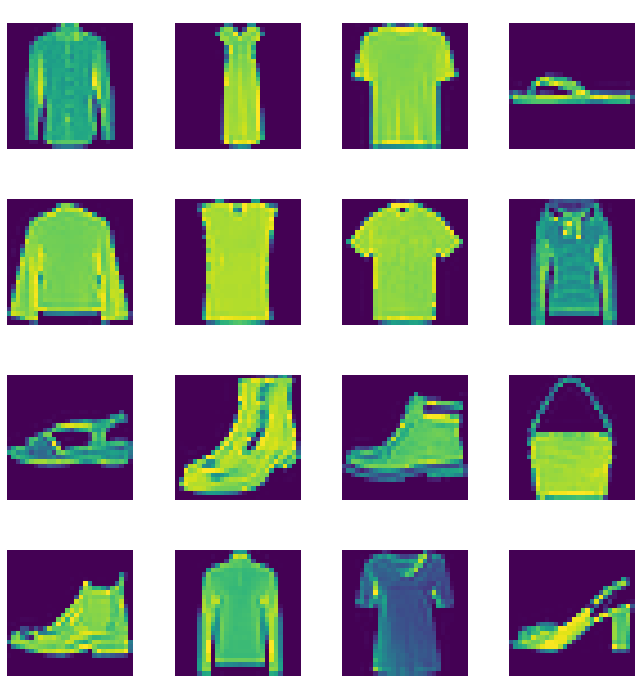

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 28, 28, 16)        80        
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 14, 14, 16)        64        
_________________________________________________________________
activation_16 (Activation)   (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 14, 14, 16)        1040      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 7, 7, 16)          0         
_________________________________________________________________
batch_normalization_17 (Batc (None, 7, 7, 16)         

In [68]:
obj1 = Pipeline().train_pipeline()

In [69]:
model = tf.keras.models.load_model(r"A:\ML\OWN_PROJECT\14_fashion\PACKAGE\MODEL\model.h5")

In [70]:
model.load_weights(r"A:\ML\OWN_PROJECT\14_fashion\PACKAGE\MODEL\model.h5")

In [31]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [32]:
X_train = X_train[:100]/255
y_train = y_train[:100]

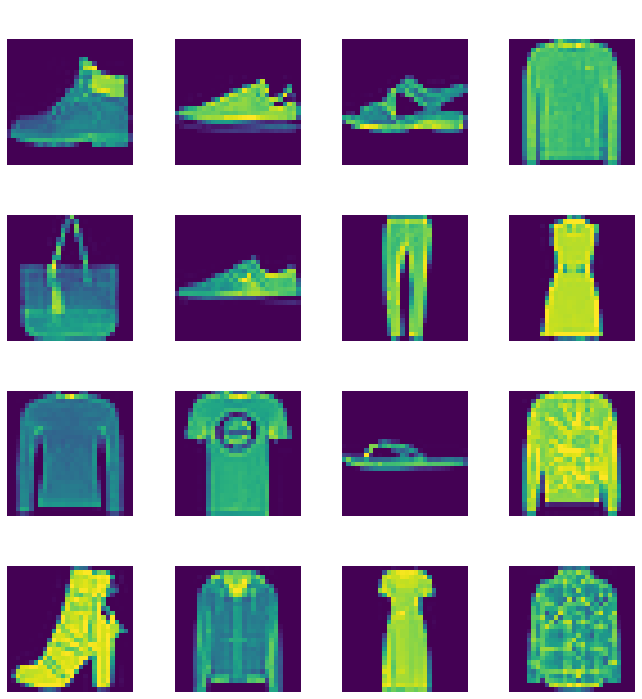

In [71]:

fig = plt.figure(figsize = (12,12))
for i in range(1, 17):
    random = np.random.randint(low = 0, high = 99)
    ax = fig.add_subplot(4, 4, i)

    image_to_pred = np.array(X_train[random]).reshape(1,28,28,1) 
    y_pred = model.predict(image_to_pred)
    y_pred = y_pred.argmax()

    ax.imshow(image_to_pred.reshape(28,28))
    ax.axis('off')
    ax.set_title('True = {0}\nPrediction = {1}'.format(y_train[random], y_pred),
                fontsize = 14, color = 'white', fontweight = 'bold')
plt.subplots_adjust(wspace = 0, hspace = 0.4)
plt.show()